#Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset,DataLoader

#Data Exploration

In [3]:
df = pd.read_csv('Sensors.csv')
df.drop(df.tail(1).index,inplace=True)
df['time'] = pd.to_datetime(df['time'],unit='s')
df = df.set_index('time')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,27) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.head()

,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],Solar [kW],temperature,icon,humidity,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 05:00:00,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,0.013083,0.000417,0.000150,0.000000,0.031350,0.001017,0.004067,0.001517,0.003483,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
2016-01-01 05:00:01,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,0.013117,0.000417,0.000150,0.000000,0.031500,0.001017,0.004067,0.001650,0.003467,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
2016-01-01 05:00:02,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,0.013083,0.000433,0.000167,0.000017,0.031517,0.001000,0.004067,0.001650,0.003467,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
2016-01-01 05:00:03,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,0.013000,0.000433,0.000217,0.000000,0.031500,0.001017,0.004067,0.001617,0.003483,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
2016-01-01 05:00:04,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,0.012783,0.000450,0.000333,0.000000,0.031500,0.001017,0.004067,0.001583,0.003467,36.14,clear-night,0.62,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0


In [13]:
df.describe()

,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],Solar [kW],temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,windBearing,precipIntensity,dewPoint,precipProbability
count,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000
mean,0.858962,0.076229,0.858962,0.031368,0.099210,0.136779,0.081287,0.063556,0.042137,0.014139,0.002755,0.007023,0.000009,0.058530,0.015642,0.010983,0.035313,0.076229,50.741935,0.664085,9.253444,48.263382,1016.301625,6.649936,202.356843,0.002598,38.694013,0.056453
std,1.058207,0.128428,1.058207,0.190951,0.169059,0.178631,0.104466,0.076199,0.057967,0.014292,0.021860,0.076740,0.000010,0.202706,0.137841,0.098859,0.096056,0.128428,19.113807,0.194389,1.611186,22.027916,7.895185,3.982716,106.520474,0.011257,19.087939,0.165836
min,0.000000,0.000000,0.000000,0.000000,0.000017,0.000067,0.000083,0.000067,0.000017,0.000017,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-12.640000,0.130000,0.270000,-32.080000,986.400000,0.000000,0.000000,0.000000,-27.240000,0.000000
25%,0.367667,0.003367,0.367667,0.000000,0.020233,0.064400,0.040383,0.005083,0.007133,0.012733,0.000500,0.000017,0.000000,0.029833,0.000983,0.003617,0.001483,0.003367,35.770000,0.510000,9.420000,31.090000,1011.290000,3.660000,148.000000,0.000000,24.600000,0.000000
50%,0.562333,0.004283,0.562333,0.000017,0.020617,0.066633,0.042217,0.005433,0.008083,0.012933,0.000667,0.000050,0.000017,0.031317,0.001000,0.004000,0.001617,0.004283,50.320000,0.680000,10.000000,50.320000,1016.530000,5.930000,208.000000,0.000000,39.030000,0.000000
75%,0.970250,0.083917,0.970250,0.000233,0.068733,0.080633,0.068283,0.125417,0.053192,0.013100,0.000750,0.000167,0.000017,0.032883,0.001017,0.004067,0.001750,0.083917,66.260000,0.840000,10.000000,66.260000,1021.480000,8.940000,295.000000,0.000000,54.790000,0.000000
max,14.714567,0.613883,14.714567,1.401767,1.934083,0.794933,0.971750,0.851267,1.273933,1.088983,1.166583,2.262583,0.000183,7.027900,1.633017,1.929800,0.465217,0.613883,93.720000,0.980000,10.000000,101.120000,1042.460000,22.910000,359.000000,0.191000,75.490000,0.840000


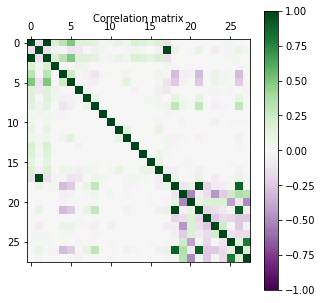

In [15]:
# Correlations matrix of original data
plt.figure(figsize=(5,5))
plt.matshow(df.corr(method='pearson'),vmax=1,vmin=-1,cmap='PRGn', fignum=1)
plt.title('Correlation matrix', size=10)
plt.colorbar()
plt.show()

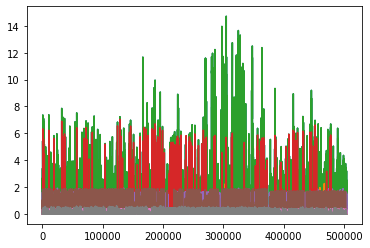

In [10]:
#Extracting only Energy data [kw] 
#Approach 1: use each appliance's historical values to predict the next time step value (this notebook's focus)
#Approach 2: use weather/humidity and other features as input, and each appliance's power consumption as targets
training_set = df.iloc[:,:18].values
plt.plot(training_set)
plt.show()

#Data Preprocessing


In [16]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 7
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [17]:
trainX.shape

torch.Size([337614, 7, 18])

In [19]:
trainY.shape

torch.Size([337614, 18])

#Models


In [20]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

#Training

In [39]:
num_epochs = 1000
learning_rate = 0.01

input_size = 18
hidden_size = 6
num_layers = 1

num_classes = 18

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
loss_ = []
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    # obtain the loss function
    loss = criterion(outputs, trainY)
    loss.backward()
    loss_.append(loss)
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.06180
Epoch: 100, loss: 0.00443
Epoch: 200, loss: 0.00302
Epoch: 300, loss: 0.00268
Epoch: 400, loss: 0.00257
Epoch: 500, loss: 0.00251
Epoch: 600, loss: 0.00249
Epoch: 700, loss: 0.00248
Epoch: 800, loss: 0.00247
Epoch: 900, loss: 0.00246


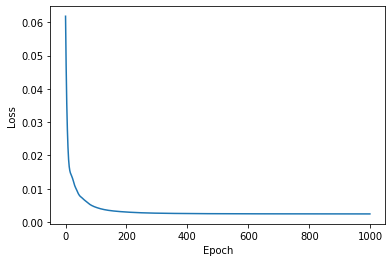

In [40]:
plt.plot(loss_)
plt.xlabel('Epoch')
plt.ylabel('Loss')
# Save the trained model
PATH = './lstm_EnergyPre.pth'
torch.save(lstm.state_dict(), PATH)

#Testing 

In [ ]:
input_size = 18
hidden_size = 6
num_layers = 1

num_classes = 18

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
PATH_lstm = './lstm_EnergyPre.pth'
lstm.load_state_dict(torch.load(PATH_lstm))

In [41]:
lstm.eval()
test_predict = lstm(testX)
data_predict = test_predict.data.numpy()
dataY_plot = testY.data.numpy()
data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(testY)

from sklearn.metrics import mean_squared_error
MAE = np.mean(np.abs([data_predict[j]-dataY_plot[j] for j in range(len(data_predict))]))
RMSE = np.sqrt(mean_squared_error(data_predict,dataY_plot))
MSE = mean_squared_error(data_predict,dataY_plot) 
print('MAE is', MAE, 'MSE is', MSE, 'RMSE is', RMSE)

MAE is 0.059883353834132694 MSE is 0.04075187646147381 RMSE is 0.2018709401114331


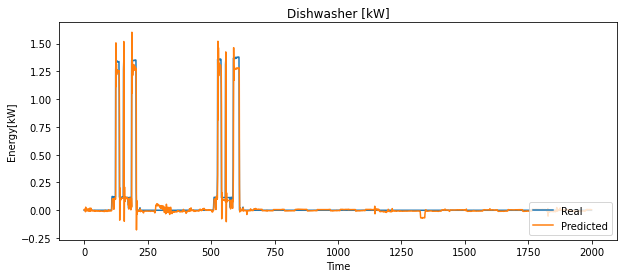

In [81]:
# plt.axvline(ab[0], c='r', linestyle='--')
feature = 3
f = plt.figure(figsize=(10,4))
plt.plot(dataY_plot[0:2000,feature])
plt.plot(data_predict[0:2000,feature])
plt.title(df.columns[feature])
plt.xlabel('Time')
plt.ylabel('Energy[kW]')
plt.legend(['Real','Predicted'],loc = 'lower right')
plt.show()
# f.savefig("case1.pdf")

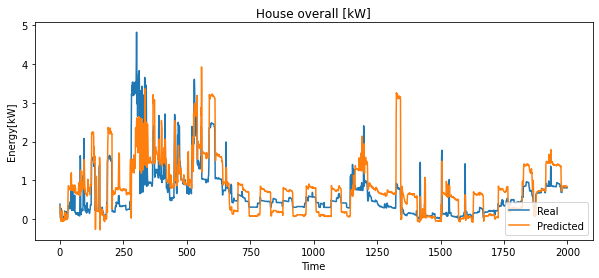

In [82]:
# plt.axvline(ab[0], c='r', linestyle='--')
feature = 2
f = plt.figure(figsize=(10,4))
plt.plot(dataY_plot[0:2000,feature])
plt.plot(data_predict[0:2000,feature])
plt.title(df.columns[feature])
plt.xlabel('Time')
plt.ylabel('Energy[kW]')
plt.legend(['Real','Predicted'],loc = 'lower right')
plt.show()
# f.savefig("case1.pdf")